In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import networkx as nx
from node2vec import Node2Vec
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
sns.set_palette("colorblind")
import utilities as ut

# conduct node2vec on the covisit edgelist

In [2]:
covisit_edgelist = pd.read_csv("covisit_edgelist.csv")
selected_brands = pd.read_csv("selected_brands.csv")['brands']
edgelist = covisit_edgelist[covisit_edgelist['brands'].isin(selected_brands) & covisit_edgelist['related_same_month_brand'].isin(selected_brands)]

In [3]:
edgelist

,brands,related_same_month_brand,weight
0,& Other Stories,BP,8.707358
1,& Other Stories,Baskin Robbins,2.515050
2,& Other Stories,Bloomingdale's,1.836120
3,& Other Stories,Burger King,14.270903
4,& Other Stories,CVS,12.640468
...,...,...,...
60789,vineyard vines,Trader Joe's,0.129199
60790,vineyard vines,Walgreens,15.018088
60791,vineyard vines,Walmart,12.505168
60792,vineyard vines,Wendy's,6.089147


In [4]:
G = nx.from_pandas_edgelist(edgelist, source = 'brands', target = 'related_same_month_brand', 
                            edge_attr = ['weight'], create_using = nx.DiGraph())

In [5]:
# get brand ses and price level for comparsion
brand_median = pd.read_csv('brand_median.csv')
yelp_labelled = pd.read_csv('yelp_labelled.csv')
brand_cat = pd.read_csv('selected_brand_cat3d.csv')[['brands', 'naics3_category']]
brand_stats = brand_median.merge(yelp_labelled, on = 'brands')
brand_stats = brand_stats.merge(brand_cat, on = 'brands').set_index('brands')

In [ ]:
random.seed(3)

def get_vectors(model):
    """
    """
    vectors = {node: model.wv[node] for node in G.nodes()}
    vectors = pd.DataFrame.from_dict(vectors, orient = 'index')
    return vectors

def get_vis_df(vectors):
    """
    """
    model = TSNE(n_components = 2, perplexity = 50)
    df = model.fit_transform(vectors)
    df = pd.DataFrame(df, index = vectors.index.values)
    df = df.sort_index()
    df = df.merge(brand_stats, left_index = True, right_index = True)
    df = df.rename(columns = {0: 'dim1', 1: 'dim2', 'median': 'ses', 'yelp_dollar': 'price', 'naics3_category': 'industry'})
    df.index.name = 'brands'
    return df 

In [7]:
model = Node2Vec(G, dimensions = 128, p = 1, q = 2, walk_length = 80, num_walks = 10, seed = 3).fit()

Computing transition probabilities:   0%|          | 0/924 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


In [8]:
vectors = get_vectors(model)
df = get_vis_df(vectors )

In [9]:
kmeans = KMeans(n_clusters = 10, random_state = 1, n_init = 10).fit(vectors)
clustered = pd.DataFrame({"cluster": kmeans.labels_, "brands": vectors.index.values}).set_index("brands")
clustered = clustered.merge(df, left_index = True, right_index = True)

In [10]:
clustered.drop(['cluster', 'industry'], axis = 1).corr()

,dim1,dim2,ses,price
dim1,1.000000,0.240093,0.338851,0.313522
dim2,0.240093,1.000000,0.008486,0.209043
ses,0.338851,0.008486,1.000000,0.362844
price,0.313522,0.209043,0.362844,1.000000


In [11]:
callout = ["McDonald's", "Save-A-Lot", "Dollar General", "Whole Foods Market", "Bloomingdale's",
           "Gucci", "Valentino", "Gap", "Trader Joe's", "Nike", "Versace", "itsu", "KFC",
           "Kings Food Markets", "Lidl", "Dollar Tree", "lululemon athletica", "Dior",
           "Walmart", "Taco Bell", "Shake Shack", "Balduccis","Woof Gang Bakery & Grooming",
           "Prada", "Tiffany & Co.", "Adidas", "Barnes and Noble", "Macy's", "Loro Piana",
           "Papa John's", "Love's Travel Stops and Country Stores", "Cinnabon", "Papa John's", 
           "Benihana", "Brooks Brothers", "New York Sports Club", "Le Pain Quotidien", "Pret A Manger", 
           "SavOn", "Movie Tavern by Marcus", "Save-A-Lot", "Denny's", "Yogurtini", "Kohl's",
           "BJ's Wholesale Club", "Applebee's", "GameStop", "Five Below", "Haagen Dazs", "Foot Locker",
           "Umami Burger", "Kate Spade", "Green's Natural Foods", "Chanel", "Gong Cha"]

/var/folders/3n/5f66kdbs79l01jvps_16tnh00000gn/T/ipykernel_6761/1423097470.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 0.9, 1])


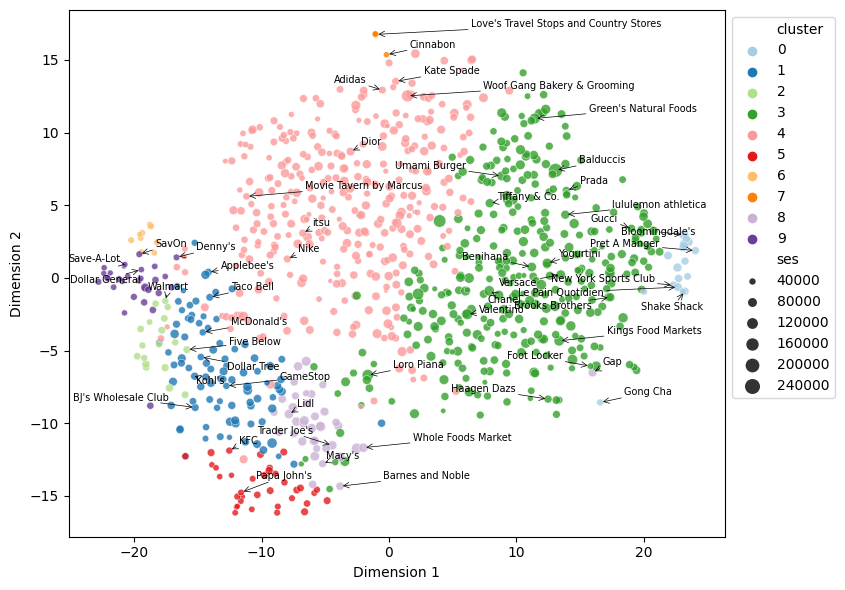

In [12]:
fig, ax = plt.subplots(figsize = (9.5, 6), constrained_layout = True)

sns.scatterplot(data = clustered, x = 'dim1', y = 'dim2', alpha = 0.8, hue = 'cluster', palette = 'Paired', size = 'ses', sizes=(10, 100))
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 0.9, 1])

TEXTS = []
for i in range(len(df)):
    if df.index[i] in callout:
        x = df["dim1"].iloc[i]
        y = df["dim2"].iloc[i]
        text = df.index[i]
        TEXTS.append(ax.text(x, y, text, fontsize = 7, weight = "roman"))

adjust_text(
    TEXTS, 
    expand_points = (2, 2),
    expand_text = (1, 1),
    expand_objects = (2, 2),
    force_points = 0.2, 
    force_text = 0.2,
    force_objects = 0.2,
    arrowprops = dict(
        arrowstyle = "->",  
        linewidth = 0.5
    ),
    ax=fig.axes[0]
)
plt.show()

In [13]:
sum_stats = clustered[['cluster', 'ses', 'price']].groupby('cluster').mean()
sum_stats = sum_stats.assign(n = clustered['cluster'].value_counts()) 
sum_stats.corr()

,ses,price,n
ses,1.000000,0.852546,0.444838
price,0.852546,1.000000,0.765962
n,0.444838,0.765962,1.000000


In [14]:
sum_stats.sort_values('ses')

,ses,price,n
cluster,,,
7,59376.500000,1.250000,4
6,61875.055556,1.375000,9
9,63912.983333,1.538462,30
5,68837.142857,1.533333,35
2,75164.277778,1.500000,18
1,84010.554945,1.641026,91
4,84371.367868,2.110266,333
0,91408.027778,2.000000,18
3,95755.808908,2.283388,348


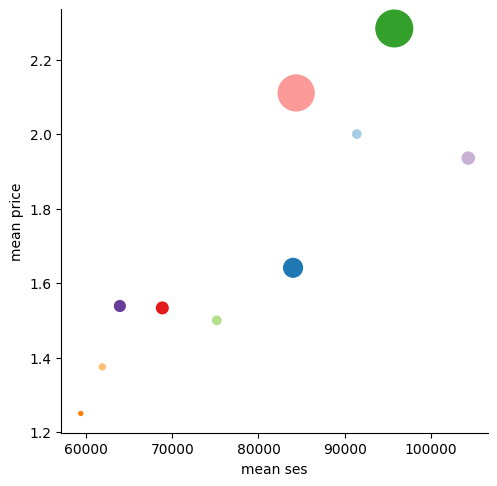

In [15]:
fig, ax = plt.subplots(figsize = (5.5, 5.5))
plt.scatter(sum_stats['ses'], sum_stats['price'], s = sum_stats['n']*2, c = sns.color_palette("Paired")[:10])
plt.xlabel("mean ses")
plt.ylabel("mean price")
sns.despine()
# for index, row in sum_stats.iterrows():
#     ax.text(row['ses'], row['price'], str(index))
plt.show()

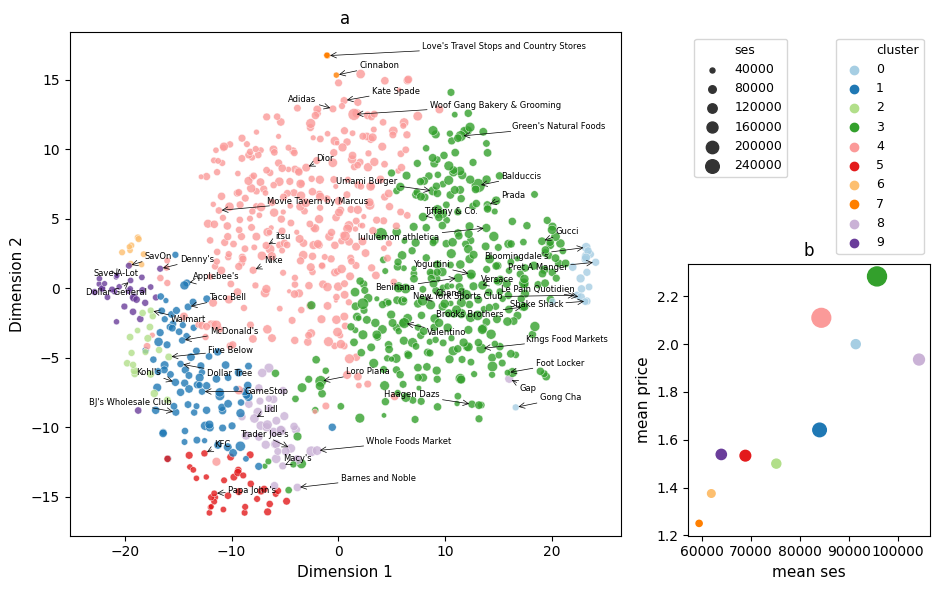

In [ ]:
fig = plt.figure(figsize=(9.5, 6))
spec = GridSpec(7, 3, figure=fig)

ax1 = fig.add_subplot(spec[:, :2])  
ax2 = fig.add_subplot(spec[3:, 2])   
ax3 = fig.add_subplot(spec[:3, 2]) # to put in legend

# plot 1
sns.scatterplot(data=clustered, x='dim1', y='dim2', alpha=0.8, hue='cluster', palette='Paired', size='ses', sizes=(10, 100), ax=ax1)
ax1.set_xlabel("Dimension 1", fontsize = 11)
ax1.set_ylabel("Dimension 2", fontsize = 11)
ax1.set_title('a')
ax1.xaxis.set_tick_params(labelsize = 10)
ax1.yaxis.set_tick_params(labelsize = 10)

# get legend to be used later
legend1 = ax1.get_legend()
ax1.legend_.remove()

TEXTS = []
for i in range(len(df)):
    if df.index[i] in callout:
        x = df["dim1"].iloc[i]
        y = df["dim2"].iloc[i]
        text = df.index[i]
        TEXTS.append(ax1.text(x, y, text, fontsize = 6, weight="roman"))

adjust_text(
    TEXTS,
    expand_points=(2, 2),
    expand_text=(1, 1),
    expand_objects=(2, 2),
    force_points=0.2,
    force_text=0.2,
    force_objects=0.2,
    arrowprops=dict(
        arrowstyle="->",
        linewidth=0.5
    ),
    ax=ax1
)

# plot 2
ax2.scatter(sum_stats['ses'], sum_stats['price'], s = np.sqrt(sum_stats['n'])*10, c=sns.color_palette("Paired")[:10])
ax2.set_xlabel("mean ses", fontsize = 11)
ax2.set_ylabel("mean price", fontsize = 11)
ax2.set_title('b')
ax2.xaxis.set_tick_params(labelsize = 10)
ax2.yaxis.set_tick_params(labelsize = 10)


# legend
ax3.axis('off')  # Hide the axes
# Separate the legend entries for 'cluster' and 'ses'
cluster_handles = legend1.legend_handles[:11]  # Adjust indices as needed
cluster_labels = [t.get_text() for t in legend1.texts[:11]]  # Adjust indices as needed
ses_handles = legend1.legend_handles[11:]  # Adjust indices as needed
ses_labels = [t.get_text() for t in legend1.texts[11:]]  # Adjust indices as needed

# Create two separate legends
legend_cluster = ax3.legend(handles=cluster_handles, labels=cluster_labels, loc='upper right', fontsize = 9)
legend_ses = ax3.legend(handles=ses_handles, labels=ses_labels, loc='upper left', fontsize = 9)

# Add the legends to the same axes
ax3.add_artist(legend_cluster)

plt.tight_layout()
plt.show()
# plt.savefig("Appendix/FigureD1.png", dpi = 300)